Perform a very simple fit to the data.

In [87]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import emcee

-0.525509606298 2.88909102256


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


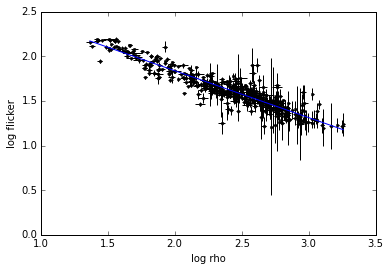

In [88]:
# load data
f, ferr, r, rerr = np.genfromtxt("../data/flickers.dat").T

# fit a line
C = np.diag(ferr)
AT = np.vstack((r, np.ones_like(r)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print(m, c)

# plot data
xs = np.linspace(min(r), max(r), 100)
ys = m * xs + c
plt.errorbar(r, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log rho")

In [89]:
def model(pars, x):
    return pars[0] * x + pars[1]

In [90]:
def lnprior(pars):
    if -10 < pars[0] < 10 and -10 < pars[1] < 10 and -10 < pars[2] < 10:
        return 0.
    else:
        return -np.inf

In [91]:
def lnprob(pars, x, y, yerr):
    return lnprior(pars) + lnlike(pars, x, y, yerr)

In [92]:
def lnlike(pars, x, y, yerr):
    invsig2 = 1./(yerr**2 + np.exp(2*pars[2]))
    model_y = model(pars, x)
    return -.5*np.sum((y-model_y)**2*invsig2 - np.log(invsig2))

Set up MCMC

In [93]:
pars_init = [m, c, np.log(3)]
print(lnlike(pars_init, r, f, ferr))

-482.639922813


In [94]:
ndim, nwalkers = 3, 24
pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(r, f, ferr))
sampler.run_mcmc(pos, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
samples[:, 2] = np.exp(samples[:, 2])
print(np.median(samples[:, 0]), np.median(samples[:, 1]), np.median(samples[:, 2]))

-0.525794412598 2.89229875575 0.0658412211417


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


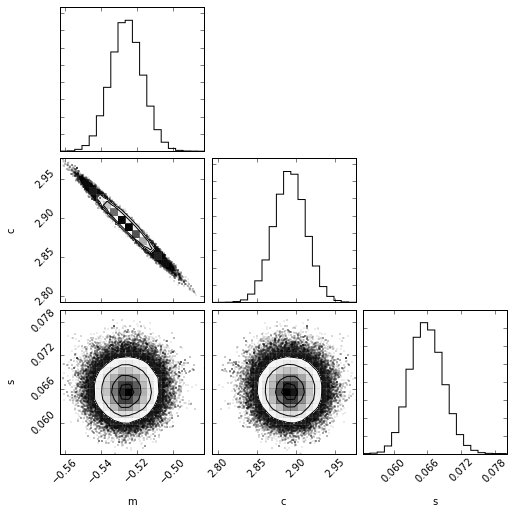

In [95]:
fig = corner.corner(samples, labels=["m", "c", "s"])

-0.826618949099 4.90659568177


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


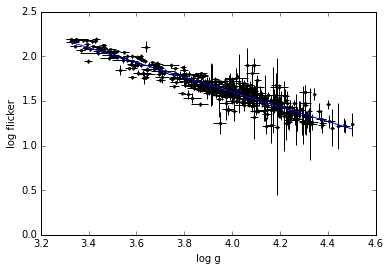

In [97]:
# load data
f, ferr, l, lerr, _, _ = np.genfromtxt("../data/log.dat").T

# fit a line
C = np.diag(ferr)
AT = np.vstack((l, np.ones_like(l)))
ATA = np.dot(AT, AT.T)
m, c = np.linalg.solve(ATA, np.dot(AT, f))
print(m, c)

# plot data
xs = np.linspace(min(l), max(l), 100)
ys = m * xs + c
plt.errorbar(l, f, xerr=rerr, yerr=ferr, fmt="k.", capsize=0)
plt.plot(xs, ys)
plt.ylabel("log flicker")
plt.xlabel("log g")

In [98]:
pars_init = [m, c, np.log(3)]
print(lnlike(pars_init, r, f, ferr))

pos = [pars_init + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(l, f, ferr))
sampler.run_mcmc(pos, 10000)
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))
samples[:, 2] = np.exp(samples[:, 2])
print(np.median(samples[:, 0]), np.median(samples[:, 1]), np.median(samples[:, 2]))

-524.660515155
-0.823849574167 4.8983622634 0.0589091357188


/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/ruthangus/anaconda/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


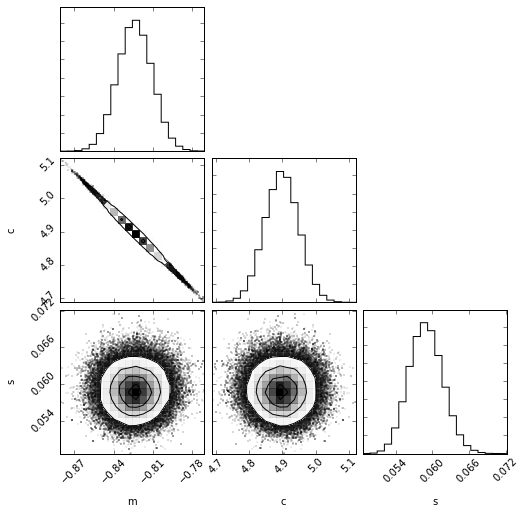

In [99]:
fig = corner.corner(samples, labels=["m", "c", "s"])